<div style="color:#fdd017;text-align:center;font-weight:bolder;font-size:1.5em;background-color: black;">

# 3. Entrenamiento / Evaluación

</div>

<div style="color:#fdd017;">

### Importamos librerías

</div>

In [49]:
# importamos las librerías necesarias
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.inspection import permutation_importance

import joblib
from datetime import datetime
import pathlib as pl
import pickle
import yaml
import sys
import os

<div style="color:#fdd017;">

### Cargamos datos limpios

</div>

In [3]:
# Lectura de datos y muestra inicial
df = pd.read_csv('..\\data\\processed\\churn_clean_v1.csv')
df.head(3)

,is_female,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,MonthlyCharges,TotalCharges,Churn,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,0,0,1,0,...,29.85,29.85,0,False,False,False,False,False,True,False
1,0,0,0,0,34,1,0,1,0,1,...,56.95,1889.50,0,False,False,True,False,False,False,True
2,0,0,0,0,2,1,0,1,1,0,...,53.85,108.15,1,False,False,False,False,False,False,True


<div style="color:#fdd017;">

## Separar datos en train / test

Dividir los datos en **train (80 %)** y **test (20 %)** nos permite entrenar modelos solo con la parte de entrenamiento y reservar un bloque “virgen” para evaluarlos una única vez al final.

</div>

In [4]:
# Definimos Features y Target
X = df.drop(columns=['Churn'])
y = df['Churn']

In [5]:
print(X.shape)
print(y.shape)

(7043, 23)
(7043,)


In [6]:
# Dividimos los datos en Train (80%) y Test (20%)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.20,
                                                    random_state=10)

In [7]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5634, 23)
(1409, 23)
(5634,)
(1409,)


<div style="color:#fdd017;">

#### Guardado de datos Train y Test

Guardamos los datos que hemos separado en Train y Test en dos CSV's para tenerlos disponibles desde otros archivos.

</div>

In [7]:
'''
X_train.to_csv('..\\data\\train\\churn_X_train_v1.csv', index=False, encoding='utf-8')
X_test.to_csv('..\\data\\test\\churn_X_test_v1.csv', index=False, encoding='utf-8')

y_train.to_csv('..\\data\\train\\churn_y_train_v1.csv', index=False, encoding='utf-8')
y_test.to_csv('..\\data\\test\\churn_y_test_v1.csv', index=False, encoding='utf-8')
'''

"\nX_train.to_csv('..\\data\\train\\churn_X_train_v1.csv', index=False, encoding='utf-8')\nX_test.to_csv('..\\data\\test\\churn_X_test_v1.csv', index=False, encoding='utf-8')\n\ny_train.to_csv('..\\data\\train\\churn_y_train_v1.csv', index=False, encoding='utf-8')\ny_test.to_csv('..\\data\\test\\churn_y_test_v1.csv', index=False, encoding='utf-8')\n"

In [8]:
X_train.head()

,is_female,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,PaperlessBilling,MonthlyCharges,TotalCharges,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
1182,0,0,0,0,57,0,0,1,0,1,...,1,53.75,3196.00,False,False,False,False,False,True,False
4328,1,0,1,0,15,1,1,0,0,0,...,1,51.10,711.15,False,False,False,False,False,True,False
6091,0,1,1,0,2,1,1,0,0,0,...,1,86.85,156.35,True,False,False,False,False,False,True
4870,0,0,0,1,48,1,1,1,1,1,...,1,64.40,3035.35,False,False,True,False,False,False,False
4683,0,0,0,0,24,1,1,0,0,0,...,1,94.10,2322.85,True,False,False,False,False,True,False


<div style="color:#fdd017;">

## Escalado de variables numéricas

Este bloque estandariza las variables numéricas (`tenure`, `MonthlyCharges`, `TotalCharges`) con **StandardScaler**, ajustando la media a 0 y la desviación típica a 1 sobre los conjuntos de entrenamiento y test. Así se evita fuga de información (*data leakage*) y se facilita el modeloado posterior.


</div>

In [8]:
# variables numéricas
numeric = ['tenure', 'MonthlyCharges', 'TotalCharges']

In [9]:
# comprobamos valores
X_train[numeric].head(3)

,tenure,MonthlyCharges,TotalCharges
1182,57,53.75,3196.00
4328,15,51.10,711.15
6091,2,86.85,156.35


In [10]:
# escalado
scaler = StandardScaler()

X_train[numeric] = scaler.fit_transform(X_train[numeric])
X_test[numeric]  = scaler.transform(X_test[numeric])

In [11]:
# volvemos a comprobar valores
X_train[numeric].head(3)

,tenure,MonthlyCharges,TotalCharges
1182,1.006161,-0.371599,0.407888
4328,-0.704607,-0.459879,-0.691949
6091,-1.234131,0.731063,-0.937513


<div style="color:#fdd017;">

---

# Objetivo de la Predicción

En nuestro caso, nuestro objetivo principal es **detectar cuándo `Churn=1`**. No vamos a ser excesivamente sensibles a la precisión. Es decir, no es tan relevante que haya algún positivo de más (falsos positivos). Priorizaremos que aquellos positivos que detecta efectivamente, sean efectivamente Churn=1.

Por lo tanto, para **maximizar el Recall para la clase 1**, y dado el desbalance de clases (26% Churn vs 74% No-Churn), utilizaremos **Classification Report** ya que proporciona automáticamente el **Recall**, nuestra prioridad, y también los **precision** y **f1-score**.

</div>

<div style="color:#fdd017;">

---

# Modelo 1 / Baseline: Logistic Regression

Aquí ajustamos una regresión logística sobre Train ya escalado con `class_weight='balanced'`, ya que como hemos indicado anteriormente, tenemos un 26% de 'Churn' frente a los clientes que no causan baja. Este parámetro ajusta el peso de cada clase (Sí/No) para que no haya un desequilibrio entre ellas.

Utilizamos `predict_proba` para obtener la probabilidad de baja para cada cliente de Test, y evaluamos su rendimiento mediante el AUC-ROC. Creamos también una **matriz de confusión** para visualizar aciertos y errores de clasificación.

Esta métrica baseline servirá de referencia para comparar modelos más complejos en fases posteriores.

</div>

<div style="color:#fdd017;">

### Entrenamiento
</div>

In [12]:
# entrenamiento con class_weight='balanced' para equilibrar las clases (Sí/No)
logreg = LogisticRegression(max_iter=1000, class_weight='balanced',random_state=10)
logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=10)

<div style="color:#fdd017;">

### Grid Search

</div>

In [14]:
# Definimos el grid de hiperparámetros
param_grid_1 = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear']  # Solvers habituales para problemas binarios
}

# Definimos la validación cruzada estratificada
cv_1 = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=10
    )

# Creamos el GridSearchCV
grid_1 = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid_1,
    scoring='recall',
    cv=cv_1,
    verbose=2,
    n_jobs=-1
)

# Entrenamos el grid
grid_1.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, random_state=10),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'solver': ['lbfgs', 'liblinear']},
             scoring='recall', verbose=2)

In [15]:
print("Mejor Estimator:", grid_1.best_estimator_)
print("Mejor AUC:", grid_1.best_score_)
print("Mejores parámetros:", grid_1.best_params_)

Mejor Estimator: LogisticRegression(C=10, class_weight='balanced', max_iter=1000,
                   random_state=10, solver='liblinear')
Mejor AUC: 0.8021086467373835
Mejores parámetros: {'C': 10, 'solver': 'liblinear'}


<div style="color:#fdd017;">

### Roc/AUC Score
</div>

In [16]:
# Probabilidades y AUC
y_proba_1 = grid_1.predict_proba(X_test)[:, 1] # generamos predicciones (probabilidad de baja)

auc_1 = roc_auc_score(y_test, y_proba_1) # comparamos las predicciones con los datos de test reales

print(f"AUC test: {auc_1:.3f}")

AUC test: 0.843


<div style="color:#fdd017;">

### Matriz de Confusión
</div>


Matriz de Confusión:
[[771 295]
 [ 74 269]]


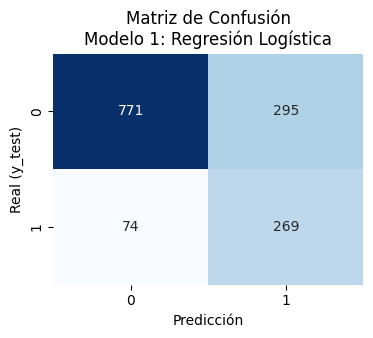

In [17]:
# Predicciones (no probabilidades)
y_pred_1 = grid_1.predict(X_test)

# Matriz de confusión
cm_1 = confusion_matrix(y_test, y_pred_1)

print("\nMatriz de Confusión:")
print(cm_1)

# Visualización con Heatmap
plt.figure(figsize=(4, 3))

sns.heatmap(cm_1,
            annot=True,
            fmt="d",
            cmap="Blues",
            cbar=False,
            xticklabels=logreg.classes_,  # Predicción
            yticklabels=logreg.classes_)  # Real
plt.xlabel("Predicción")
plt.ylabel("Real (y_test)")
plt.title("Matriz de Confusión\nModelo 1: Regresión Logística")
plt.show()

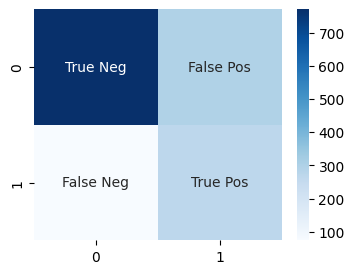

In [18]:
# Nice confusion matrix catalog visuals examples
plt.figure(figsize=(4, 3))
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(
    cm_1,
    annot=labels,
    fmt='',
    cmap='Blues'
    );

<div style="color:#fdd017;">

### Classification Report
</div>

In [19]:
# Calcular Precision
precision_1 = precision_score(y_test, y_pred_1, pos_label=1)
print(f"Precisión (Churn): {precision_1:.3f}")

# Calcular Recall
recall_1 = recall_score(y_test, y_pred_1, pos_label=1)
print(f"Recall (Churn): {recall_1:.3f}")

# Calcular Accuracy (Exactitud)
accuracy_1 = accuracy_score(y_test, y_pred_1)
print(f"Exactitud (Accuracy): {accuracy_1:.3f}")

# classification report
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_1, target_names=['No Churn', 'Churn']))

Precisión (Churn): 0.477
Recall (Churn): 0.784
Exactitud (Accuracy): 0.738

Reporte de Clasificación:
              precision    recall  f1-score   support

    No Churn       0.91      0.72      0.81      1066
       Churn       0.48      0.78      0.59       343

    accuracy                           0.74      1409
   macro avg       0.69      0.75      0.70      1409
weighted avg       0.81      0.74      0.75      1409



<div style="color:#fdd017;">

Con un AUC = 0,843 el modelo base logra **una predicción acertada del 84 % de los clientes**. Es un dato bastante sólido para un baseline, aunque todavía hay margen de mejora con modelos más complejos o ajustes de hiperparámetros.

Apreciamos también un buen **Recall (78%) para predecir el Churn**, lo cual es crucial para identificar a la mayoría de los clientes que se van (nuestro objetivo, precisamente). Sin embargo, tiene un número significativo de **Falsos Positivos (295)**, indicando que predice incorrectamente que muchos clientes se irán cuando no lo hacen, y 74 **Falsos Negativos**, que son clientes que sí se fueron y el modelo no detectó. El AUC de 0.843 es una buena línea base, pero los Falsos Negativos y Falsos Positivos son áreas clave a mejorar con modelos más avanzados.

</div>

<div style="color:#fdd017;">

### Guardamos el Modelo Baseline y el Scaler

</div>

In [20]:
'''joblib.dump({
    'model'      : grid_1,
    'scaler'     : scaler,
    'cont_cols'  : numeric,
    'columns'    : X_train.columns       # orden exacto de features
}, '../models/model_1_logreg_baseline_v1.pkl')'''

"joblib.dump({\n    'model'      : grid_1,\n    'scaler'     : scaler,\n    'cont_cols'  : numeric,\n    'columns'    : X_train.columns       # orden exacto de features\n}, '../models/model_1_logreg_baseline_v1.pkl')"

<div style="color:#fdd017;">

### Registro de métricas

Registramos los resultados de cada modelo en un CSV para tener el historial, que guardaremos en `/docs`.

</div>

In [21]:
results_path = pl.Path('../data/processed/resultados.csv')

row = {
    'fecha'  : dt.date.today(),
    'modelo' : 'Baseline_Logistic_Regression',
    'params' : grid_1.best_params_,
    'precision': precision_1,
    'recall' : recall_1,
    'accuracy': accuracy_1,
    'auc'    : auc_1
}

# añade nueva fila al CSV
pd.DataFrame([row]).to_csv(
    results_path,
    mode   = "a", # añadir
    header = not results_path.exists(), # escribe cabecera solo si el fichero no existe
    index  = False
)

<div style="color:#fdd017;">

---

## Modelos Avanzados

Después de definir una Baseline (con AUC = 0,843), pasamos a **modelos Ensemble** —Random Forest y XGBoost—, adecuados para un problema de clasificación.

El objetivo es comprobar si estos métodos hacen mejores predicciones y analizar cuáles son las variables más influyentes según _feature importance_ para cada modelo.

</div>

<div style="color:#fdd017;">

---

# Modelo 2 : Random Forest

</div>

<div style="color:#fdd017;">

### Entrenamiento
</div>

In [22]:
# configuración del modelo
rf = RandomForestClassifier(
        random_state=10,
        class_weight="balanced"
)

# entrenamiento del modelo
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=10)

<div style="color:#fdd017;">

### Grid Search
</div>

In [23]:
param_grid_2 = {
    'n_estimators': [200, 400, 600],  # número de árboles
    'max_depth': [10, 12, 15],        # profundidad máxima
    'min_samples_split': [2, 5],      # mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2]        # mínimo de muestras en las hojas
}

# Validación cruzada estratificada para dividir los datos en k particiones 
#(en este caso, 5 “folds”) de manera que la proporción de clases (Churn=1 y Churn=0) 
# se mantenga igual en cada partición que en el dataset original.
# importante en mi caso, donde tengo unaclase minoritaria con el 25% de los datos (Churn=1)

cv_2 = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=10
    )

# Creamos el GridSearchCV
grid_2 = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_2,
    scoring='recall',
    cv=cv_2, # cross validation de 5 folds
    verbose=2,
    n_jobs=-1
)

# Entrenamos el grid search
grid_2.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=10),
             n_jobs=-1,
             param_grid={'max_depth': [10, 12, 15], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [200, 400, 600]},
             scoring='recall', verbose=2)

In [24]:
print("Mejor Estimator:", grid_2.best_estimator_)
print("Mejor AUC:", grid_2.best_score_)
print("Mejores parámetros:", grid_2.best_params_)

Mejor Estimator: RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, n_estimators=600, random_state=10)
Mejor AUC: 0.7182385085181614
Mejores parámetros: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 600}


<div style="color:#fdd017;">

### Roc/AUC Score
</div>

In [25]:
# Probabilidades y AUC
y_proba_2 = grid_2.predict_proba(X_test)[:, 1] # generamos predicciones (probabilidad de baja)

auc_2 = roc_auc_score(y_test, y_proba_2) # comparamos las predicciones con los datos de test reales

print(f"AUC test - Random Forest: {auc_2:.3f}")

AUC test - Random Forest: 0.848


<div style="color:#fdd017;">

### Matriz de Confusión
</div>


Matriz de Confusión:
[[857 209]
 [ 93 250]]


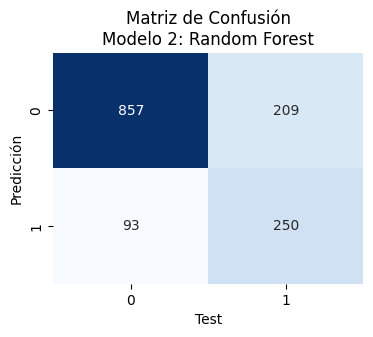

In [26]:
# Predicciones (no probabilidades)
y_pred_2 = grid_2.predict(X_test)

# Matriz de confusión
cm_2 = confusion_matrix(y_test, y_pred_2)

print("\nMatriz de Confusión:")
print(cm_2)

# Visualización con Heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cm_2, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel("Test")
plt.ylabel("Predicción")
plt.title("Matriz de Confusión\nModelo 2: Random Forest")
plt.show()

<div style="color:#fdd017;">

### Classification Report
</div>

In [27]:
# Calcular Precision
precision_2 = precision_score(y_test, y_pred_2, pos_label=1)
print(f"Precisión (Churn): {precision_2:.3f}")

# Calcular Recall
recall_2 = recall_score(y_test, y_pred_2, pos_label=1)
print(f"Recall (Churn): {recall_2:.3f}")

# Calcular Accuracy (Exactitud)
accuracy_2 = accuracy_score(y_test, y_pred_2)
print(f"Exactitud (Accuracy): {accuracy_2:.3f}")

# classification report
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_2, target_names=['No Churn', 'Churn']))

Precisión (Churn): 0.545
Recall (Churn): 0.729
Exactitud (Accuracy): 0.786

Reporte de Clasificación:
              precision    recall  f1-score   support

    No Churn       0.90      0.80      0.85      1066
       Churn       0.54      0.73      0.62       343

    accuracy                           0.79      1409
   macro avg       0.72      0.77      0.74      1409
weighted avg       0.82      0.79      0.79      1409



<div style="color:#fdd017;">

Con Random Forest hemos mejorado el AUC ligeramente respecto al modelo base (de 84,3% hemos pasado al 84,8%). Sin embargo, el Recall* para la clase Churn positiva se ha visto reducida de 0.78 a 0.73, lo que implica más clientes que se dan de baja sin ser detectados.


Para nuestro caso, donde priorizamos captar el máximo número de posibles bajas, **el modelo no resulta más conveniente**, a pesar de la mejora en accuracy y en precisión.

_(*) Recall es la sensibilidad o habilidad del modelo para identificar True Positives._


</div>

<div style="color:#fdd017;">

### Guardamos el Modelo y el Scaler

</div>

In [28]:
'''joblib.dump({
    'model'      : grid_2,
    'scaler'     : scaler,
    'cont_cols'  : numeric,
    'columns'    : X_train.columns       # orden exacto de features
}, '../models/model_2_rf_v2.pkl')'''

"joblib.dump({\n    'model'      : grid_2,\n    'scaler'     : scaler,\n    'cont_cols'  : numeric,\n    'columns'    : X_train.columns       # orden exacto de features\n}, '../models/model_2_rf_v2.pkl')"

<div style="color:#fdd017;">

### Registro de métricas

Registramos los resultados de cada modelo en un CSV para tener el historial, que guardaremos en `/docs`.

</div>

In [29]:
results_path = pl.Path('../data/processed/resultados.csv')

row = {
    'fecha'  : dt.date.today(),
    'modelo' : 'RandomForest',
    'params' : grid_2.best_params_,
    'precision': precision_2,
    'recall' : recall_2,
    'accuracy': accuracy_2,
    'auc'    : auc_2
}

# añade nueva fila al CSV
pd.DataFrame([row]).to_csv(
    results_path,
    mode   = "a", # añadir
    header = not results_path.exists(), # escribe cabecera solo si el fichero no existe
    index  = False
)

<div style="color:#fdd017;">

---

# Modelo 3 : XG Boost

</div>

<div style="color:#fdd017;">

### Configuración del Modelo XG Boost Classifier

</div>

In [13]:
# configuración del modelo XG Boost Classifier
xgb = XGBClassifier(
        objective='binary:logistic', # típico para un problema binario (Churn / No Churn) y salida en forma de probabilidad (0-1)
        eval_metric='auc',
        scale_pos_weight=3, # 75 : 25 ≈ 3 (balance del target)
        random_state=10
    )

<div style="color:#fdd017;">

### Grid Search

</div>

In [14]:
param_grid_3 = {
    'n_estimators': [300, 400, 500, 1000],
    'learning_rate': [0.015, 0.02, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6]
}

cv_3 = StratifiedKFold(
    n_splits=5, 
    shuffle=True, 
    random_state=10
    )

grid_3 = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_3,
    scoring='recall',
    cv=cv_3,
    verbose=2,
    n_jobs=-1
)

grid_3.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_poli...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.015, 0.02, 0.05, 0.1],
                         'max_depth': [3, 4, 5, 6],
                         'n_estimators': [300, 400, 500, 1000]},
             scoring='recall', verbose=2)

<div style="color:#fdd017;">

### Roc/AUC Score
</div>

In [15]:
print("Mejor Estimator:", grid_3.best_estimator_)
print("Mejor AUC:", grid_3.best_score_)
print("Mejores parámetros:", grid_3.best_params_)

Mejor Estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.015, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=None, num_parallel_tree=None, ...)
Mejor AUC: 0.8257023465123755
Mejores parámetros: {'learning_rate': 0.015, 'max_depth': 3, 'n_estimators': 400}


In [16]:
# Probabilidades y AUC
y_proba_3 = grid_3.predict_proba(X_test)[:, 1] # generamos predicciones (probabilidad de baja)

auc_3 = roc_auc_score(y_test, y_proba_3) # comparamos las predicciones con los datos de test reales

print(f"AUC test - XG Boost Classifier: {auc_3:.3f}")

AUC test - XG Boost Classifier: 0.846


<div style="color:#fdd017;">

### Matriz de Confusión
</div>


Matriz de Confusión:
[[760 306]
 [ 61 282]]


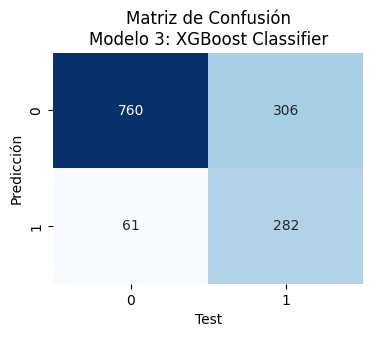

In [18]:
# Predicciones (no probabilidades)
y_pred_3 = grid_3.predict(X_test)

# Matriz de confusión
cm_3 = confusion_matrix(y_test, y_pred_3)

print("\nMatriz de Confusión:")
print(cm_3)

# Visualización con Heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cm_3, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=grid_3.classes_, yticklabels=grid_3.classes_)
plt.xlabel("Test")
plt.ylabel("Predicción")
plt.title("Matriz de Confusión\nModelo 3: XGBoost Classifier")
plt.show()

<div style="color:#fdd017;">

### Classification Report
</div>

In [19]:
# Calcular Precision
precision_3 = precision_score(y_test, y_pred_3, pos_label=1)
print(f"Precisión (Churn): {precision_3:.3f}")

# Calcular Recall
recall_3 = recall_score(y_test, y_pred_3, pos_label=1)
print(f"Recall (Churn): {recall_3:.3f}")

# Calcular Accuracy (Exactitud)
accuracy_3 = accuracy_score(y_test, y_pred_3)
print(f"Exactitud (Accuracy): {accuracy_3:.3f}")

# classification report
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_3, target_names=['No Churn', 'Churn']))

Precisión (Churn): 0.480
Recall (Churn): 0.822
Exactitud (Accuracy): 0.740

Reporte de Clasificación:
              precision    recall  f1-score   support

    No Churn       0.93      0.71      0.81      1066
       Churn       0.48      0.82      0.61       343

    accuracy                           0.74      1409
   macro avg       0.70      0.77      0.71      1409
weighted avg       0.82      0.74      0.76      1409



<div style="color:#fdd017;">

El modelo XGBoost Classifier, tras ajustar sus hiperparámetros con Grid Search, ha logrado un **recall para la clase Churn del 82,2%**, el valor más alto entre los modelos evaluados hasta el momento. Esto significa que identifica correctamente 8 de cada 10 clientes que realmente causan baja, cumpliendo el principal objetivo de este proyecto: minimizar la pérdida de clientes no detectados, aunque implique una mayor tasa de falsos positivos.

El AUC del modelo (0.846) es similar al del modelo base, pero el incremento en recall justifica su uso cuando la prioridad es anticipar el churn por encima de la precisión. Por tanto, **XGBoost se presenta como la mejor opción** si queremos maximizar la capacidad de detección de bajas, incluso a costa de aceptar algunas falsas alarmas.

</div>

<div style="color:#fdd017;">

### Guardamos el Modelo

</div>

In [47]:
'''joblib.dump({
    'model'      : grid_3,
    'scaler'     : scaler,
    'cont_cols'  : numeric,
    'columns'    : X_train.columns       # orden exacto de features
}, '../models/model_3_grid_xgb_v5.pkl')'''

['../models/model_3_grid_xgb_v5.pkl']

<div style="color:#fdd017;">

### Registro de métricas

Registramos los resultados de cada modelo en un CSV para tener el historial, que guardaremos en `/docs`.

</div>

In [20]:
results_path = pl.Path('../data/processed/resultados.csv')

row = {
    'fecha'  : dt.date.today(),
    'modelo' : 'XGBoost Classifier',
    'params' : str(grid_3.best_params_),
    'precision': precision_3,
    'recall' : recall_3,
    'accuracy': accuracy_3,
    'auc'    : auc_3
}

# añade nueva fila al CSV
pd.DataFrame([row]).to_csv(
    results_path,
    mode   = "a", # añadir
    header = not results_path.exists(), # escribe cabecera solo si el fichero no existe
    index  = False
)

<div style="color:#fdd017;">

---

# Modelo Final

Trataremos de mejorar el modelo final (XGBoost).

</div>

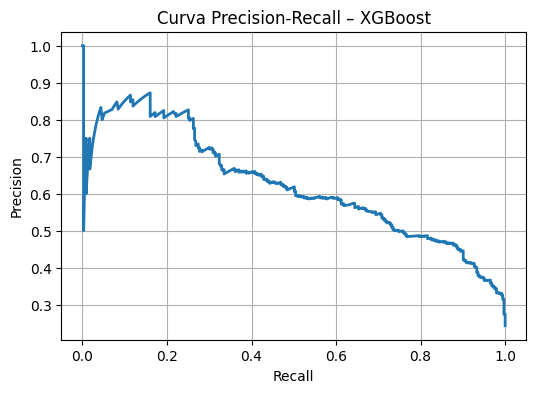

In [21]:
#reminder: `y_proba_3` eran las predicciones en probabilidad de que los clientes causen baja.
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_3)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall – XGBoost")
plt.grid(True)
plt.show()


<div style="color:#fdd017;">

### Qué podemos ver en la curva Precision/Recall:

Para lograr el **`Recall` ≥ 0.85** que nos interesa, vamos a tener que aceptar una `Precision` cerca de 0.45.

Eso significa que aprox. **el 55 % de las detecciones serán “falsas alarmas”**.
Confirmaremos con "Negocio" si el coste de la gestión de esos clientes (potenciales Churn que no vamos a predecir satisfactoriamente) es asumible frente al beneficio de retener a los clientes que realmente iban a causar baja.

A continuación detectaremos cuál es el punto exacto (`Threshold` o umbral) en el que el `Recall` será del 0.85.

</div>

In [22]:
# necesario para que los 3 datos (threshold, recall y precision) tengan el mismo índice
thresholds = np.append(thresholds, 1.0)  

# índice de la primera posición donde el recall alcanza 0.85
idx = np.where(recall >= 0.85)[0][-1] # selecciona el mayor threshold con recall >=0.85

recall_objetivo = recall[idx]        # debería ser ≈0.85 o superior
precision_en_thres = precision[idx]
threshold_final = thresholds[idx]

print(f"Threshold elegido: {threshold_final:.3f}")
print(f"Recall:  {recall_objetivo:.3f}")
print(f"Precision: {precision_en_thres:.3f}")


Threshold elegido: 0.466
Recall:  0.851
Precision: 0.471


<div style="color:#fdd017;">

### AUC Final
</div>

In [23]:
# Predicciones - Probabilidades
y_proba_final = grid_3.predict_proba(X_test)[:, 1]

auc_final = roc_auc_score(y_test, y_proba_final) # comparamos las predicciones con los datos de test reales

print(f"AUC test - XG Boost Classifier con Threshold ajustado: {auc_final:.3f}")

AUC test - XG Boost Classifier con Threshold ajustado: 0.846


<div style="color:#fdd017;">

### Matriz de Confusión Final
</div>


Matriz de Confusión Final:
[[738 328]
 [ 51 292]]


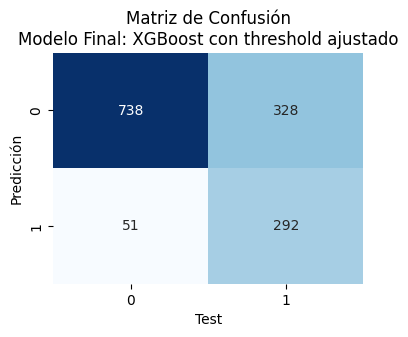

In [24]:
# Predicciones - Etiquetas
y_pred_final = (y_proba_final >= threshold_final).astype(int) # Threshold/umbral óptimo con recall >=0.85

# Matriz de confusión
cm_final = confusion_matrix(y_test, y_pred_final, labels=[0, 1])

print("\nMatriz de Confusión Final:")
print(cm_final)

# Visualización con Heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cm_final, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Test")
plt.ylabel("Predicción")
plt.title("Matriz de Confusión\nModelo Final: XGBoost con threshold ajustado")

plt.show()

<div style="color:#fdd017;">

### Classification Report Final
</div>

In [25]:
# Calcular Precision
precision_final = precision_score(y_test, y_pred_final, pos_label=1)
print(f"Precisión (Churn): {precision_final:.3f}")

# Calcular Recall
recall_final = recall_score(y_test, y_pred_final, pos_label=1)
print(f"Recall (Churn): {recall_final:.3f}")

# Calcular Accuracy (Exactitud)
accuracy_final = accuracy_score(y_test, y_pred_final)
print(f"Exactitud (Accuracy): {accuracy_final:.3f}")

# classification report
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_final, target_names=['No Churn', 'Churn']))

Precisión (Churn): 0.471
Recall (Churn): 0.851
Exactitud (Accuracy): 0.731

Reporte de Clasificación:
              precision    recall  f1-score   support

    No Churn       0.94      0.69      0.80      1066
       Churn       0.47      0.85      0.61       343

    accuracy                           0.73      1409
   macro avg       0.70      0.77      0.70      1409
weighted avg       0.82      0.73      0.75      1409



<div style="color:#fdd017;">

### Guardamos el Modelo Final

El modelo sigue siendo el XGBoost Classifier con Grid Search y los mejores parámetros (el mismo Modelo 3), sin embargo, para que las predicciones no consideren un umbral de corte (threshold) del 0,50 (el que se usa por defecto), le especificamos que el corte debe ser el que hemos detectado (0.466, para que nos de un Recall de 0.85).

Para que el pickle también 'recuerde' el corte elegido, creamos un "wrapper" con el 'best_estimator' y el 'threshold'.
</div>

In [42]:
class ChurnModel:
    def __init__(self, estimator, threshold):
        self.estimator  = estimator      # el XGBoost entrenado del Modelo 3
        self.threshold  = threshold      # 0.466 calculado

    def predict_proba(self, X):
        "Devuelve las probabilidades sin tocar nada"
        return self.estimator.predict_proba(X)

    def predict(self, X):
        "Aplica el corte al canal positivo"
        proba_pos = self.predict_proba(X)[:, 1]
        return (proba_pos >= self.threshold).astype(int)

In [43]:
# Wrapper con el mejor estimador y el threshold óptimo

final_model = ChurnModel(grid_3.best_estimator_, threshold=0.466)

'''joblib.dump({
    "model"     : final_model, # el wrapper
    "scaler"    : scaler,
    "cont_cols" : numeric,
    "columns"   : X_train.columns
}, "../models/final_model_v0.pkl")'''

'joblib.dump({\n    "model"     : final_model, # el wrapper\n    "scaler"    : scaler,\n    "cont_cols" : numeric,\n    "columns"   : X_train.columns\n}, "../models/final_model_v0.pkl")'

In [45]:

'''
# CÓMO CARGAR Y PREDECIR DESDE OTRO SCRIPT
pkg = joblib.load("../models/xgb_churn_thr046.pkl")
X_new = pd.read_csv("Nuevos_clientes.csv")[pkg["columns"]]
X_new[pkg["cont_cols"]] = pkg["scaler"].transform(X_new[pkg["cont_cols"]])
y_pred = pkg["model"].predict(X_new)
probas = pkg["model"].predict_proba(X_new)[:, 1]

'''

'\n# CÓMO CARGAR Y PREDECIR DESDE OTRO SCRIPT\npkg = joblib.load("../models/xgb_churn_thr046.pkl")\nX_new = pd.read_csv("Nuevos_clientes.csv")[pkg["columns"]]\nX_new[pkg["cont_cols"]] = pkg["scaler"].transform(X_new[pkg["cont_cols"]])\ny_pred = pkg["model"].predict(X_new)\nprobas = pkg["model"].predict_proba(X_new)[:, 1]\n\n'

<div style="color:#fdd017;">

### Guardamos la Configuración del Modelo Final

</div>

In [51]:
# 1. Cargamos el paquete que guardaste con joblib.dump(...)
pkg_path = pl.Path("../models/final_model_v0.pkl")
pkg      = joblib.load(pkg_path)      # {'model', 'scaler', ...}

# 2. Extraemos el modelo real (el wrapper ChurnModel o un estimador normal)
model = pkg["model"] if isinstance(pkg, dict) else pkg
inner  = getattr(model, "estimator", model)   # estimador “real”

# 3. Hiperparámetros
params = {}
if hasattr(inner, "best_params_"):          # GridSearchCV
    params = inner.best_params_
elif hasattr(inner, "get_params"):          # scikit-learn genérico
    params = inner.get_params(deep=False)
elif hasattr(inner, "get_xgb_params"):      # XGBClassifier
    params = inner.get_xgb_params()
else:
    params = {}

# 4. Diccionario de configuración
config = {
    "model_type"      : type(inner).__name__,
    "library"         : inner.__module__,
    "hyperparameters" : params,
    "threshold"       : getattr(model, "threshold", None),
    "training_datetime": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
}

# 5. Guardar YAML junto al pkl
config_path = pkg_path.with_suffix(".yaml")
config_path.parent.mkdir(exist_ok=True)

with config_path.open("w", encoding="utf-8") as f:
    yaml.dump(config, f, sort_keys=False, allow_unicode=True)

print(f"✅ Configuración guardada en {config_path.resolve()}")

✅ Configuración guardada en C:\Users\xabi\Documents\ML_churn\churn_prediction\models\final_model_v0.yaml


<div style="color:#fdd017;">

### Registro de métricas

Registramos los resultados de cada modelo en un CSV para tener el historial, que guardaremos en `/docs`.

</div>

In [46]:
results_path = pl.Path('../data/processed/resultados.csv')

row = {
    'fecha'  : dt.date.today(),
    'modelo' : 'XGBoost Classifier Threshold 0.46',
    'params' : str(grid_3.best_params_),
    'precision': precision_final,
    'recall' : recall_final,
    'accuracy': accuracy_final,
    'auc'    : auc_final
}

# añade nueva fila al CSV
pd.DataFrame([row]).to_csv(
    results_path,
    mode   = "a", # añadir
    header = not results_path.exists(), # escribe cabecera solo si el fichero no existe
    index  = False
)


In [49]:
# pip install pyyaml

Note: you may need to restart the kernel to use updated packages.
